# VGGIsh Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender
- Includes visualisations & analysis

The dataset is highly unbalanced.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, L1L2

# Optuna import
import optuna

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical tests
from scipy.stats import levene

from IPython.display import display
import time

In [2]:
# Track running time (including analysis)
start_time = time.time()

In [3]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


#### TOTAL RESULTS ACROSS SEED INITIATION

In [4]:
# Lists to collect statistics across all CVs
all_losses, all_accuracies, all_precisions, all_recalls, all_f1 = [], [], [], [], []
average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1 = [], [], [], [], []
all_majority_vote_accuracies, all_majority_vote_details, all_class_stats, all_gender_stats  = [], [], [], []

# training accuracies
all_best_training_acc = []
total_training_acc = []

# Lists to collect confusion matrices across all CVs and seeds
all_confusion_matrices = []

## Define Functions

In [5]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [6]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [7]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [8]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "vggish-categorical-logs.txt" 

In [9]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

In [10]:
def styled_barplot_with_average(data, x, y, title, xlabel, ylabel, average_line=None):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 
    
    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")
    
    if average_line is not None:
        plt.axhline(y=average_line, color='red', linestyle='--', 
                    label=f'Macro-Averaged Accuracy: {average_line:.1f}%')
        plt.legend(fontsize=10)
    
    plt.show()

In [11]:
def plot_all_metrics(losses, accuracies, precisions, recalls, f1, metrics_across, x_axis_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    seeds = range(1, len(losses) + 1)

    ax.plot(seeds, losses, marker='o', color='blue', label='Loss')
    ax.plot(seeds, accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(seeds, precisions, marker='o', color='red', label='Precision')
    ax.plot(seeds, recalls, marker='o', color='purple', label='Recall')
    ax.plot(seeds, f1, marker='o', color='orange', label='F1 Score')

    ax.set_title(f'Metrics Across {metrics_across}')
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Metric Value')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True)

    return fig

In [12]:
# store epoch accs
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

# RANDOM SEED 1

## Prepare Data

In [13]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('vggish_looped_embeddings.csv')



def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [14]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [15]:
tf.keras.backend.clear_session()

## Run Setup

In [16]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

    # log cm
    all_confusion_matrices.append(cm)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
        ..
026C     1
041A     1
092A     1
076A     1
026B     1
Name: cat_id, Length: 86, dtype: int64
Testing Set Group Distribution:
055A    20
067A    19
097A    16
039A    12
116A    12
068A    11
036A    11
014B    10
040A    10
022A     9
051B     9
013B     8
099A     7
053A     6
008A     6
109A     6
023A     6
104A     4
062A     4
060A     3
011A     2
061A     2
049A     1
088A     1
110A     1
024A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
M    293
X    266
F    181
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
X    82
F    71
M    44
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [006A, 000A, 033A, 071A, 097B, 019A, 074A, 020...
kitten    [044A, 111A, 046A, 047A, 042A, 050A, 043A, 041...
senior    [093A, 015A, 001A, 103A, 028A, 057A, 106A, 101...
Name: cat

Testing Set Age Group Distribution AFTER SWAP:
adult     149
senior     40
kitten     31
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 311, 2: 266, 1: 140})
Epoch 1/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.4462 - accuracy: 0.4589
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.0385 - accuracy: 0.5690
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8688 - accuracy: 0.6109
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8565 - accuracy: 0.6192
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8335 - accuracy: 0.6179
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7890 - accuracy: 0.6541
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7830 - accuracy: 0.6625
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7607 - accuracy: 0.6457

Train Age Group Distribution BEFORE SWAP:
adult     356
senior    200
kitten    138
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
senior    106
adult     104
kitten     33
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     356
senior    200
kitten    138
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
senior    106
adult     104
kitten     33
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 356, 2: 200, 1: 138})
Epoch 1/1500
6/6 [==============================] - 0s 2ms/step - loss: 1.3534 - accuracy: 0.4236
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9174 - accuracy: 0.5692
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9033 - accuracy: 0.5893
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7862 - accuracy: 0.6282
Epoch 5/1500
6/6 [==========================

Epoch 1/1500
6/6 [==============================] - 0s 2ms/step - loss: 1.3928 - accuracy: 0.4276
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9349 - accuracy: 0.5724
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8855 - accuracy: 0.5829
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8053 - accuracy: 0.6434
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7837 - accuracy: 0.6368
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7221 - accuracy: 0.6987
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7092 - accuracy: 0.6737
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6645 - accuracy: 0.6934
Epoch 9/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6449 - accuracy: 0.7105
Epoch 10/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6484 - accuracy: 0.7276
Epoch 11/1500
6/6 [

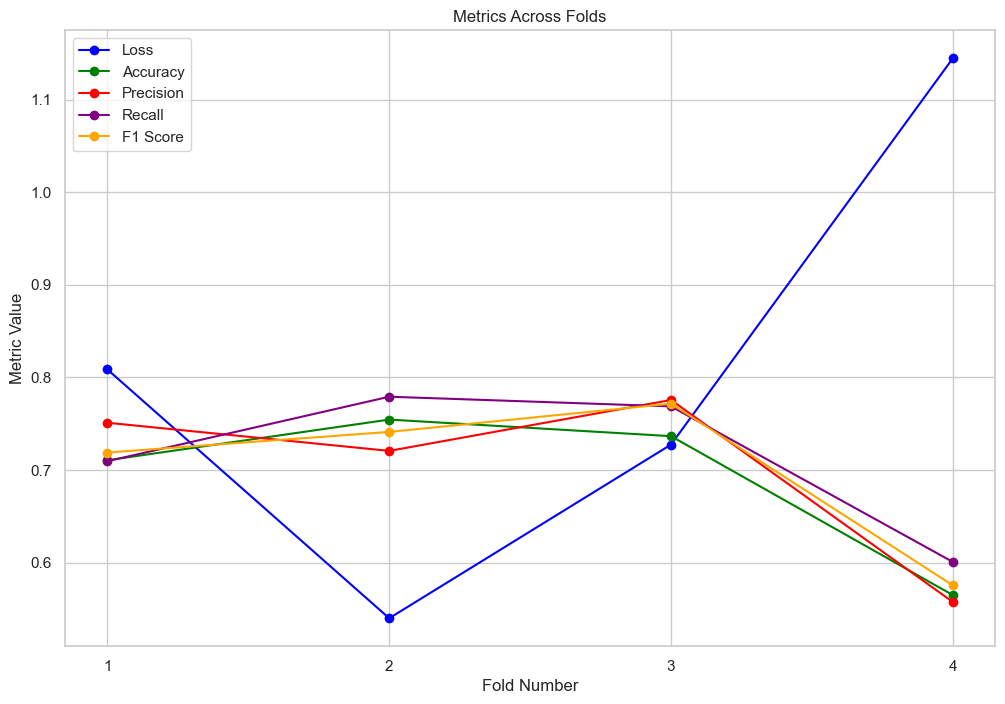

In [17]:
seed_1_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_1_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_1_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [18]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 837, Predictions: 837, Actuals: 837, Gender: 837


In [19]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [20]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.69 (76/110)


In [21]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, adult, adult, senior, adult, adult, a...",adult,adult,True
62,056A,"[senior, senior, senior]",senior,senior,True
78,072A,"[adult, kitten, adult, adult, adult, adult, ad...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, senior]",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,065A,"[adult, senior, adult, adult, adult, senior, k...",adult,adult,True
70,064A,"[adult, adult, adult]",adult,adult,True
68,062A,"[adult, adult, adult, adult]",adult,adult,True


In [23]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  72.131148           61
1           kitten  86.666667           15
2           senior  55.882353           34


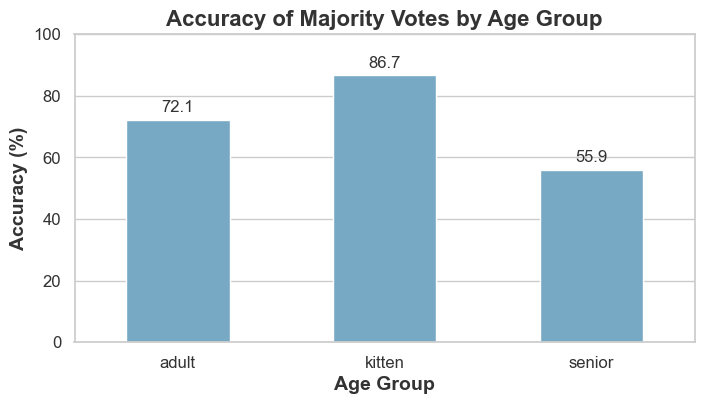

In [24]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [25]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  69.668246          422
1           kitten  82.568807          109
2           senior  65.686275          306


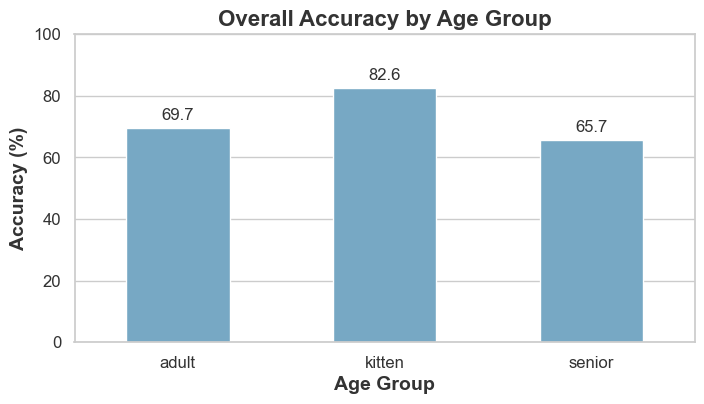

In [26]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [27]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    214      158     73.83
1          M    337      223     66.17
2          X    286      204     71.33


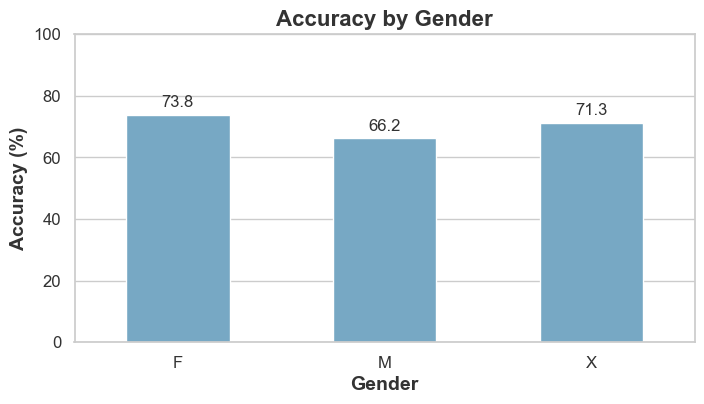

In [28]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [29]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.668246          422
1           kitten  82.568807          109
2           senior  65.686275          306]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    214      158     73.83
1          M    337      223     66.17
2          X    286      204     71.33]


# RANDOM SEED 2

In [30]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1]))
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('vggish_looped_embeddings.csv')



def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [31]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [32]:
tf.keras.backend.clear_session()

## Run Setup

In [33]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

    # log cm
    all_confusion_matrices.append(cm)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
057A    27
074A    25
020A    23
055A    20
067A    19
000B    19
029A    17
019A    17
101A    15
042A    14
059A    14
097B    14
001A    14
028A    13
111A    13
002A    13
039A    12
051A    12
116A    12
025A    11
036A    11
040A    10
016A    10
071A    10
005A    10
014B    10
051B     9
072A     9
065A     9
010A     8
095A     8
013B     8
094A     8
050A     7
027A     7
109A     6
023A     6
007A     6
108A     6
008A     6
021A     5
070A     5
025C     5
075A     5
023B     5
044A     5
034A     5
035A     4
003A     4
062A     4
009A     4
052A     4
104A     4
012A     3
064A     3
058A     3
006A     3
056A     3
113A     3
060A     3
014A     3
025B     2
061A     2
102A     2
087A     2
038A     2
093A     2
054A     2
032A     2
069A     2
092A     1
024A     1
090A     1
091A     1
115A     1
019B     1
041A     1
004A     1
076A     1
026C     1
073A     1
026B     1
Name: cat_i

Age group distribution: Counter({0: 386, 2: 252, 1: 130})
Epoch 1/1500
6/6 [==============================] - 0s 3ms/step - loss: 1.1262 - accuracy: 0.4974
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8921 - accuracy: 0.5612
Epoch 3/1500
6/6 [==============================] - 0s 2ms/step - loss: 0.8772 - accuracy: 0.5781
Epoch 4/1500
6/6 [==============================] - 0s 2ms/step - loss: 0.7989 - accuracy: 0.6224
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7502 - accuracy: 0.6549
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7456 - accuracy: 0.6510
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6693 - accuracy: 0.6836
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6744 - accuracy: 0.6797
Epoch 9/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6395 - accuracy: 0.7070
Epoch 10/1500
6/6 [==============================] - 0s 2ms/

Epoch 1/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.3031 - accuracy: 0.4315
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9988 - accuracy: 0.5297
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.0101 - accuracy: 0.5436
Epoch 4/1500
6/6 [==============================] - 0s 2ms/step - loss: 0.8657 - accuracy: 0.5823
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8384 - accuracy: 0.6017
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7838 - accuracy: 0.6390
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7833 - accuracy: 0.6501
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7640 - accuracy: 0.6376
Epoch 9/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7236 - accuracy: 0.6929
Epoch 10/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7738 - accuracy: 0.6556
Epoch 11/1500
6/6 [

Majority Vote Accuracy for cat_id for this fold: 0.83 (24/29)
Before appending - Cat IDs: 169, Predictions: 169, Actuals: 169, Gender: 169
After appending - Cat IDs: 383, Predictions: 383, Actuals: 383, Gender: 383
Final Test Results - Loss: 0.44120293855667114, Accuracy: 0.7803738117218018, Precision: 0.8051651651651651, Recall: 0.8226190476190477, F1 Score: 0.812671669814527
Confusion Matrix:
 [[92  2 26]
 [ 1 23  0]
 [18  0 52]]
outer_fold 3
Train Set Group Distribution:
046A    63
000A    39
047A    28
057A    27
074A    25
020A    23
055A    20
000B    19
067A    19
019A    17
097A    16
001A    14
097B    14
106A    14
059A    14
111A    13
028A    13
002A    13
039A    12
036A    11
025A    11
068A    11
063A    11
040A    10
071A    10
016A    10
014B    10
051B     9
045A     9
065A     9
022A     9
072A     9
033A     9
015A     9
094A     8
117A     7
027A     7
031A     7
099A     7
023A     6
037A     6
053A     6
007A     6
025C     5
070A     5
044A     5
021A     5
023B

Moved to Training/Validation Set:
{'000A', '046A'}
Removed from Training/Validation Set:
{'087A', '110A'}
Moved to Test Set:
{'087A', '110A'}
Removed from Test Set
{'000A', '046A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '002A' '002B' '003A' '005A' '007A' '008A' '009A' '010A' '011A'
 '013B' '014B' '015A' '018A' '019B' '020A' '022A' '023B' '025A' '025B'
 '025C' '026A' '026B' '026C' '028A' '029A' '031A' '032A' '033A' '034A'
 '036A' '037A' '038A' '041A' '042A' '043A' '045A' '046A' '047A' '048A'
 '049A' '050A' '051A' '051B' '053A' '054A' '056A' '058A' '059A' '060A'
 '062A' '063A' '066A' '067A' '068A' '069A' '070A' '071A' '072A' '075A'
 '076A' '088A' '090A' '093A' '094A' '095A' '096A' '097A' '099A' '100A'
 '101A' '102A' '103A' '104A' '105A' '106A' '108A' '109A' '111A' '113A'
 '115A' '116A' '117A']
AFTER SWAP - Unique Test Group IDs:
['000B' '001A' '004A' '006A' '012A' '014A' '016A' '019A' '021A' '023A'
 '024A' '027A' '035A' '039A' '040A' '044A' '052A' '055A' '057A' '061A'

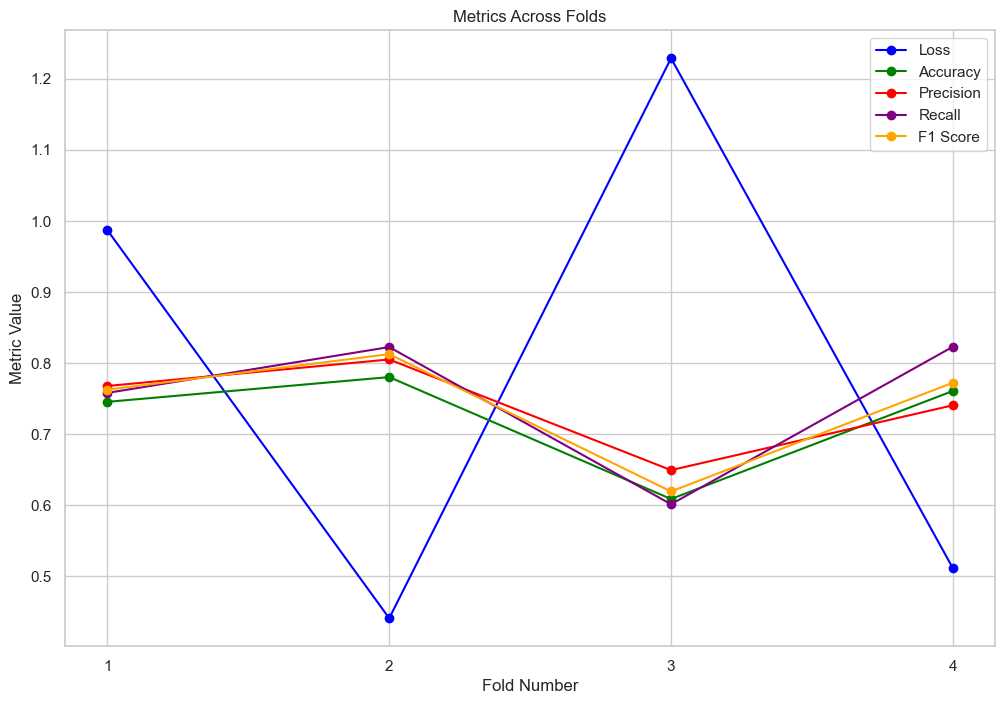

In [34]:
seed_2_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_2_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_2_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [35]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 838, Predictions: 838, Actuals: 838, Gender: 838


In [36]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [37]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.77 (85/110)


In [38]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [39]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, adult, adult, adult, adult, adult, ad...",adult,adult,True
64,058A,"[senior, adult, senior]",senior,senior,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, senior]",adult,adult,True
74,068A,"[adult, adult, adult, adult, adult, adult, sen...",adult,adult,True
73,067A,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, k...",adult,adult,True
70,064A,"[kitten, adult, adult]",adult,adult,True


In [40]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  78.688525           61
1           kitten  93.333333           15
2           senior  67.647059           34


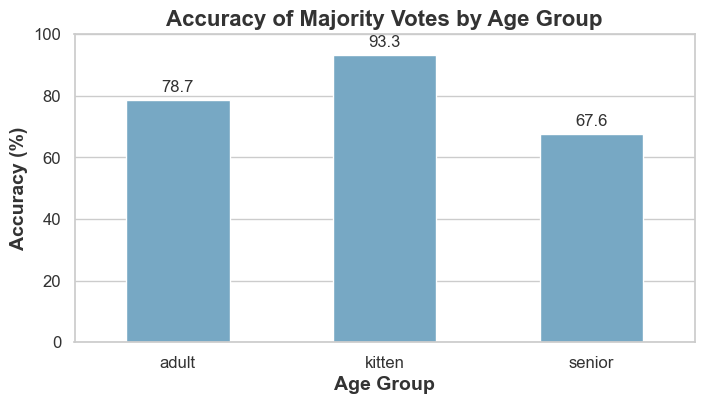

In [41]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [42]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  71.158392          423
1           kitten  83.486239          109
2           senior  69.607843          306


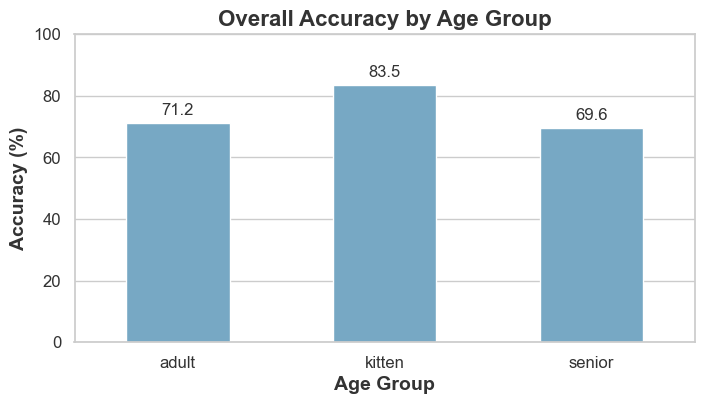

In [43]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [44]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      159     74.65
1          M    339      221     65.19
2          X    286      225     78.67


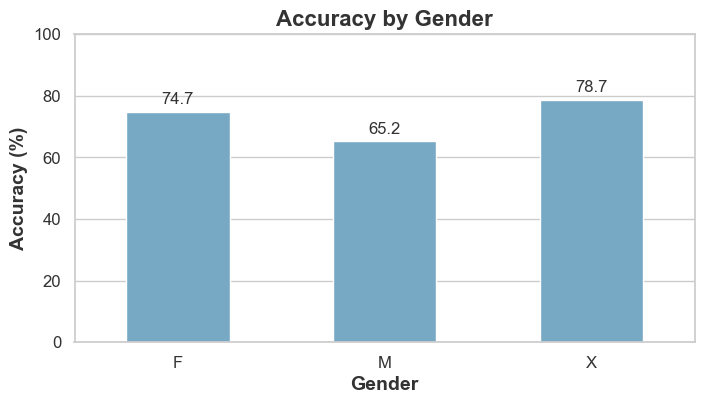

In [45]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [46]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909, 0.7727272727272727]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.668246          422
1           kitten  82.568807          109
2           senior  65.686275          306,   actual_age_group   accuracy  total_count
0            adult  71.158392          423
1           kitten  83.486239          109
2           senior  69.607843          306]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    214      158     73.83
1          M    337      223     66.17
2          X    286      204     71.33,   all_gender  count  correct  accuracy
0          F    213      159     74.65
1          M    339      221     65.19
2          X    286      225     78.67]


# RANDOM SEED 3

In [47]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('vggish_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [48]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [49]:
tf.keras.backend.clear_session()

## Run Setup

In [50]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

    # log cm
    all_confusion_matrices.append(cm)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
000A    39
002B    32
047A    28
057A    27
074A    25
020A    23
067A    19
019A    17
101A    15
059A    14
001A    14
042A    14
106A    14
002A    13
028A    13
116A    12
039A    12
051A    12
025A    11
063A    11
016A    10
040A    10
071A    10
051B     9
072A     9
065A     9
045A     9
022A     9
095A     8
013B     8
010A     8
099A     7
050A     7
027A     7
108A     6
109A     6
007A     6
053A     6
008A     6
037A     6
023A     6
023B     5
070A     5
025C     5
034A     5
044A     5
052A     4
009A     4
104A     4
035A     4
026A     4
062A     4
064A     3
012A     3
058A     3
006A     3
056A     3
113A     3
014A     3
060A     3
011A     2
102A     2
025B     2
032A     2
018A     2
093A     2
038A     2
069A     2
087A     2
092A     1
088A     1
024A     1
090A     1
100A     1
110A     1
091A     1
004A     1
041A     1
048A     1
066A     1
076A     1
096A     1
043A     1
073A     1
049A     1
026B     1
Name: cat_i

Length of groups_train_val:
735
No common groups found between train and test sets.
Train Age Group Distribution BEFORE SWAP:
adult     344
senior    262
kitten    129
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
adult     116
senior     44
kitten     42
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     344
senior    262
kitten    129
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     116
senior     44
kitten     42
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 344, 2: 262, 1: 129})
Epoch 1/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.4300 - accuracy: 0.4354
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9824 - accuracy: 0.5320
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8290 - accuracy: 0.6000
Epoch 4/1500
6/6 [==============================] - 0s 1ms


Testing Set Group Distribution:
101A    15
001A    14
106A    14
042A    14
059A    14
039A    12
116A    12
063A    11
045A     9
095A     8
044A     5
104A     4
052A     4
018A     2
025B     2
102A     2
069A     2
032A     2
093A     2
038A     2
092A     1
048A     1
004A     1
091A     1
100A     1
024A     1
026B     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    290
M    278
F    212
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
M    59
X    58
F    40
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [006A, 000A, 033A, 071A, 097B, 019A, 074A, 067...
kitten    [014B, 111A, 040A, 046A, 047A, 109A, 050A, 043...
senior    [015A, 097A, 103A, 028A, 057A, 055A, 025A, 113...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
adult     [095A, 063A, 038A, 069A, 032A, 018A, 092A, 052...
kitten                             [044A, 042A, 045A, 048

Majority Vote Accuracy for cat_id for this fold: 0.74 (20/27)
Before appending - Cat IDs: 442, Predictions: 442, Actuals: 442, Gender: 442
After appending - Cat IDs: 599, Predictions: 599, Actuals: 599, Gender: 599
Final Test Results - Loss: 0.9553160667419434, Accuracy: 0.662420392036438, Precision: 0.6578291542059658, Recall: 0.6445656457279859, F1 Score: 0.649781415456356
Confusion Matrix:
 [[16  4 19]
 [ 6 23  0]
 [24  0 65]]
outer_fold 4
Train Set Group Distribution:
046A    63
103A    33
047A    28
020A    23
055A    20
067A    19
000B    19
029A    17
097A    16
101A    15
001A    14
059A    14
097B    14
106A    14
042A    14
111A    13
039A    12
116A    12
051A    12
063A    11
036A    11
068A    11
014B    10
005A    10
071A    10
016A    10
065A     9
033A     9
045A     9
015A     9
022A     9
094A     8
095A     8
027A     7
031A     7
050A     7
099A     7
117A     7
008A     6
053A     6
109A     6
007A     6
075A     5
023B     5
044A     5
021A     5
070A     5
003A  

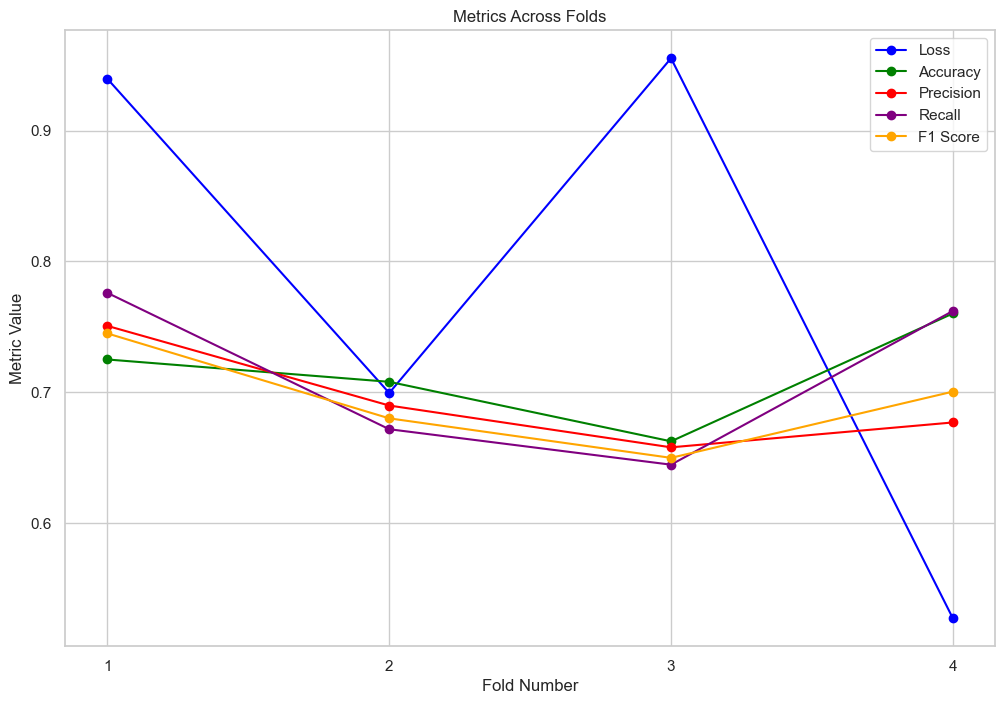

In [51]:
seed_3_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_3_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_3_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [52]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 845, Predictions: 845, Actuals: 845, Gender: 845


In [53]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [54]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.75 (83/110)


In [55]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [56]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, adult, senior, adult, kitten, a...",adult,adult,True
81,075A,"[senior, adult, adult, adult, adult]",adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, kitten, adult, adult, adult, adult, ad...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, senior]",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[adult, senior, adult, adult, adult, senior, a...",adult,adult,True


In [57]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  75.409836           61
1           kitten  73.333333           15
2           senior  76.470588           34


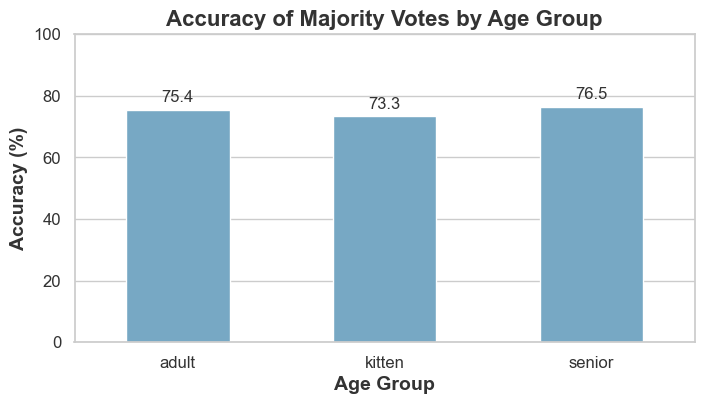

In [58]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [59]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  69.767442          430
1           kitten  80.733945          109
2           senior  71.895425          306


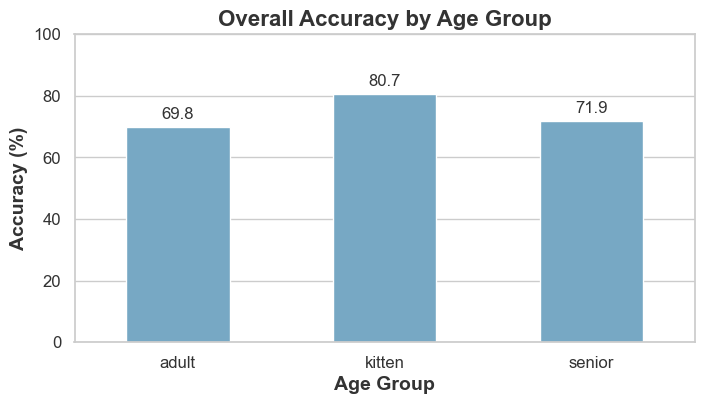

In [60]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [61]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    222      155     69.82
1          M    337      234     69.44
2          X    286      219     76.57


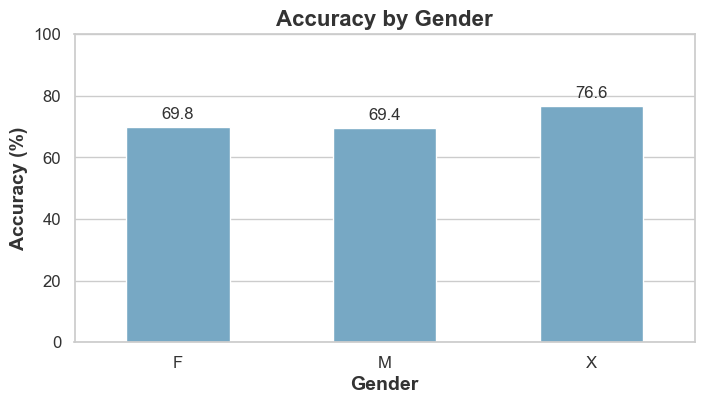

In [62]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [63]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909, 0.7727272727272727, 0.7545454545454545]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.668246          422
1           kitten  82.568807          109
2           senior  65.686275          306,   actual_age_group   accuracy  total_count
0            adult  71.158392          423
1           kitten  83.486239          109
2           senior  69.607843          306,   actual_age_group   accuracy  total_count
0            adult  69.767442          430
1           kitten  80.733945          109
2           senior  71.895425          306]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    214      158     73.83
1          M    337      223     66.17
2          X    286      204     71.33,   all_gender  count  correct  accuracy
0          F    213      159     74.65
1          M    339      221     65.19
2          X    286      225     78.67,   al

# RANDOM SEED 4

In [64]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('vggish_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [65]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [66]:
tf.keras.backend.clear_session()

## Run Setup

In [67]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

    # log cm
    all_confusion_matrices.append(cm)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
055A    20
067A    19
000B    19
029A    17
019A    17
101A    15
042A    14
059A    14
097B    14
106A    14
002A    13
051A    12
039A    12
036A    11
068A    11
040A    10
071A    10
005A    10
016A    10
014B    10
051B     9
072A     9
033A     9
065A     9
045A     9
010A     8
094A     8
013B     8
095A     8
050A     7
117A     7
027A     7
007A     6
108A     6
053A     6
008A     6
109A     6
023A     6
037A     6
044A     5
075A     5
070A     5
021A     5
025C     5
026A     4
105A     4
035A     4
104A     4
003A     4
062A     4
052A     4
058A     3
064A     3
056A     3
014A     3
012A     3
006A     3
102A     2
025B     2
032A     2
018A     2
054A     2
069A     2
087A     2
093A     2
011A     2
110A     1
100A     1
090A     1
019B     1
024A     1
076A     1
004A     1
048A     1
066A     1
026C     1
041A     1
092A     1
049A     1
043A     1
091A     1
026B     1
Name: cat_i

AFTER SWAP - Unique Test Group IDs:
['001A' '009A' '015A' '020A' '022A' '023B' '025A' '028A' '031A' '034A'
 '038A' '047A' '057A' '060A' '061A' '063A' '073A' '074A' '088A' '096A'
 '097A' '099A' '111A' '113A' '115A' '116A']
Length of X_train_val:
684
Length of y_train_val:
684
Length of groups_train_val:
684
No common groups found between train and test sets.
Train Age Group Distribution BEFORE SWAP:
adult     359
senior    196
kitten    129
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
senior    110
adult     101
kitten     42
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     359
senior    196
kitten    129
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
senior    110
adult     101
kitten     42
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 359, 2: 196, 1: 129})
Epoch 1/1500
6/6 [==============================] - 0s 2ms/step - loss: 1.39

Age group distribution: Counter({0: 363, 2: 223, 1: 134})
Epoch 1/1500
6/6 [==============================] - 0s 2ms/step - loss: 1.4744 - accuracy: 0.4181
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.0492 - accuracy: 0.5361
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8833 - accuracy: 0.5861
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8326 - accuracy: 0.6208
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7864 - accuracy: 0.6347
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7514 - accuracy: 0.6250
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7145 - accuracy: 0.6514
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.6694
Epoch 9/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6496 - accuracy: 0.6972
Epoch 10/1500
6/6 [==============================] - 0s 1ms/

Epoch 1/1500
6/6 [==============================] - 0s 2ms/step - loss: 1.3452 - accuracy: 0.4645
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9957 - accuracy: 0.5671
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9239 - accuracy: 0.5645
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8517 - accuracy: 0.6263
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7979 - accuracy: 0.6447
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8225 - accuracy: 0.6289
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7188 - accuracy: 0.6553
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6960 - accuracy: 0.6816
Epoch 9/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6758 - accuracy: 0.6921
Epoch 10/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6512 - accuracy: 0.7145
Epoch 11/1500
6/6 [

Age group distribution: Counter({0: 316, 2: 271, 1: 145})
Epoch 1/1500
6/6 [==============================] - 0s 2ms/step - loss: 1.4080 - accuracy: 0.4454
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.0201 - accuracy: 0.5587
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9607 - accuracy: 0.5546
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9146 - accuracy: 0.5915
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8062 - accuracy: 0.6434
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8461 - accuracy: 0.6598
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7825 - accuracy: 0.6544
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7050 - accuracy: 0.6817
Epoch 9/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7256 - accuracy: 0.7131
Epoch 10/1500
6/6 [==============================] - 0s 1ms/

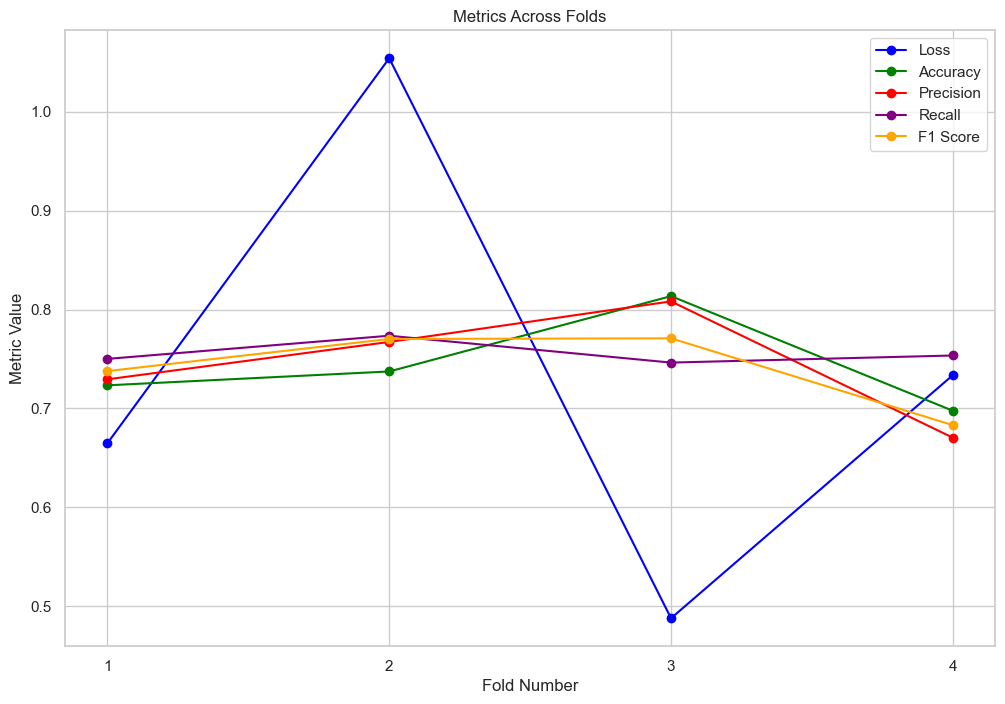

In [68]:
seed_4_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_4_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_4_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [69]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 852, Predictions: 852, Actuals: 852, Gender: 852


In [70]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [71]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.77 (85/110)


In [72]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [73]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, kitten, adult, adult, adult, adult, a...",adult,adult,True
49,043A,[kitten],kitten,kitten,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, senior]",adult,adult,True
74,068A,"[adult, adult, senior, adult, adult, adult, se...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[adult, adult, kitten, adult, adult, senior, k...",adult,adult,True


In [74]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  78.688525           61
1           kitten  86.666667           15
2           senior  70.588235           34


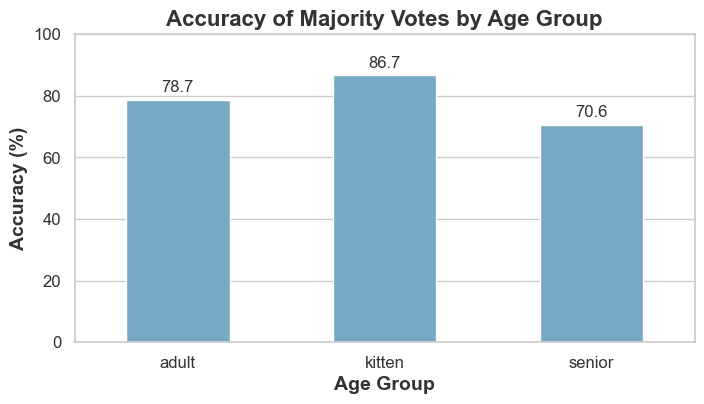

In [75]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [76]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  71.561772          429
1           kitten  83.760684          117
2           senior  73.529412          306


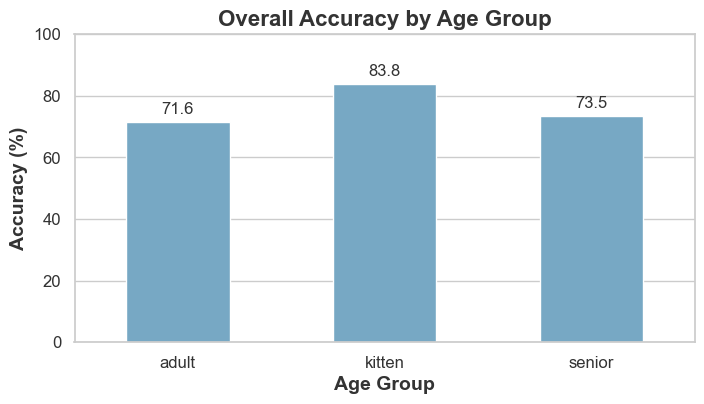

In [77]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [78]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    213      157     73.71
1          M    345      246     71.30
2          X    294      227     77.21


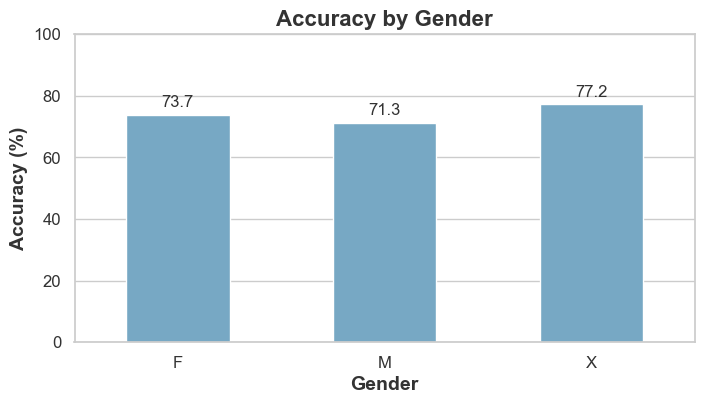

In [79]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [80]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909, 0.7727272727272727, 0.7545454545454545, 0.7727272727272727]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.668246          422
1           kitten  82.568807          109
2           senior  65.686275          306,   actual_age_group   accuracy  total_count
0            adult  71.158392          423
1           kitten  83.486239          109
2           senior  69.607843          306,   actual_age_group   accuracy  total_count
0            adult  69.767442          430
1           kitten  80.733945          109
2           senior  71.895425          306,   actual_age_group   accuracy  total_count
0            adult  71.561772          429
1           kitten  83.760684          117
2           senior  73.529412          306]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    214      158     73.83
1          M    337      223     66.17
2       

# RANDOM SEED 5

In [81]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('vggish_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     460
senior    306
kitten    171
Name: age_group, dtype: int64


In [82]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [83]:
tf.keras.backend.clear_session()

## Run Setup

In [84]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.003109800273709165)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(128, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  # units_l0 and activation from parameters
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.44571035356880917))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=128,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

    # log cm
    all_confusion_matrices.append(cm)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)

outer_fold 1
Train Set Group Distribution:
046A    63
000A    39
103A    33
002B    32
047A    28
057A    27
074A    25
020A    23
067A    19
029A    17
019A    17
101A    15
001A    14
106A    14
111A    13
028A    13
039A    12
116A    12
051A    12
063A    11
036A    11
068A    11
025A    11
040A    10
014B    10
071A    10
016A    10
005A    10
072A     9
022A     9
033A     9
015A     9
065A     9
045A     9
094A     8
095A     8
010A     8
117A     7
031A     7
027A     7
007A     6
108A     6
023A     6
008A     6
053A     6
037A     6
075A     5
070A     5
034A     5
044A     5
023B     5
021A     5
104A     4
026A     4
035A     4
009A     4
003A     4
052A     4
058A     3
006A     3
012A     3
056A     3
113A     3
014A     3
060A     3
102A     2
025B     2
069A     2
018A     2
054A     2
038A     2
087A     2
032A     2
092A     1
019B     1
090A     1
100A     1
091A     1
088A     1
073A     1
004A     1
048A     1
096A     1
043A     1
026C     1
026B     1
Name: cat_i

Moved to Training/Validation Set:
set()
Removed from Training/Validation Set:
set()
Moved to Test Set:
set()
Removed from Test Set
set()
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '001A' '002B' '003A' '004A' '005A' '006A' '007A' '008A' '009A'
 '010A' '012A' '014A' '014B' '015A' '016A' '018A' '019A' '019B' '020A'
 '021A' '022A' '023A' '023B' '025A' '025B' '026A' '026B' '026C' '027A'
 '028A' '029A' '031A' '032A' '033A' '034A' '035A' '036A' '037A' '038A'
 '039A' '040A' '043A' '044A' '045A' '046A' '047A' '048A' '051A' '052A'
 '053A' '054A' '056A' '057A' '058A' '060A' '063A' '065A' '067A' '068A'
 '069A' '070A' '071A' '072A' '073A' '074A' '075A' '087A' '088A' '090A'
 '091A' '092A' '094A' '095A' '096A' '100A' '101A' '102A' '103A' '104A'
 '106A' '108A' '111A' '113A' '116A' '117A']
AFTER SWAP - Unique Test Group IDs:
['000B' '002A' '011A' '013B' '024A' '025C' '041A' '042A' '049A' '050A'
 '051B' '055A' '059A' '061A' '062A' '064A' '066A' '076A' '093A' '097A'
 '097B' '099A' '105A' 

Epoch 1/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.1952 - accuracy: 0.4978
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9531 - accuracy: 0.5883
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8420 - accuracy: 0.6350
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7994 - accuracy: 0.6482
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7376 - accuracy: 0.6803
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7362 - accuracy: 0.6788
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6562 - accuracy: 0.7095
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6665 - accuracy: 0.6920
Epoch 9/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6603 - accuracy: 0.7022
Epoch 10/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.6051 - accuracy: 0.7212
Epoch 11/1500
6/6 [

Testing Set Age Group Distribution BEFORE SWAP:
senior    98
adult     91
kitten    64
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     369
senior    208
kitten    157
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
senior    98
adult     91
kitten    14
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 369, 2: 208, 1: 157})
Epoch 1/1500
6/6 [==============================] - 0s 2ms/step - loss: 1.3669 - accuracy: 0.4332
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9804 - accuracy: 0.5381
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8378 - accuracy: 0.5858
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8327 - accuracy: 0.5926
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7985 - accuracy: 0.6131
Epoch 6/1500
6/6 [==============================] - 0s 1ms/step - 

Testing Set Age Group Distribution AFTER SWAP:
adult     130
kitten     52
senior     48
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 330, 2: 258, 1: 119})
Epoch 1/1500
6/6 [==============================] - 0s 1ms/step - loss: 1.2416 - accuracy: 0.4908
Epoch 2/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.9581 - accuracy: 0.5389
Epoch 3/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8979 - accuracy: 0.5728
Epoch 4/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8299 - accuracy: 0.5997
Epoch 5/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.8303 - accuracy: 0.5955
Epoch 6/1500
6/6 [==============================] - 0s 2ms/step - loss: 0.7741 - accuracy: 0.6506
Epoch 7/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7409 - accuracy: 0.6535
Epoch 8/1500
6/6 [==============================] - 0s 1ms/step - loss: 0.7499 - accuracy: 0.6605

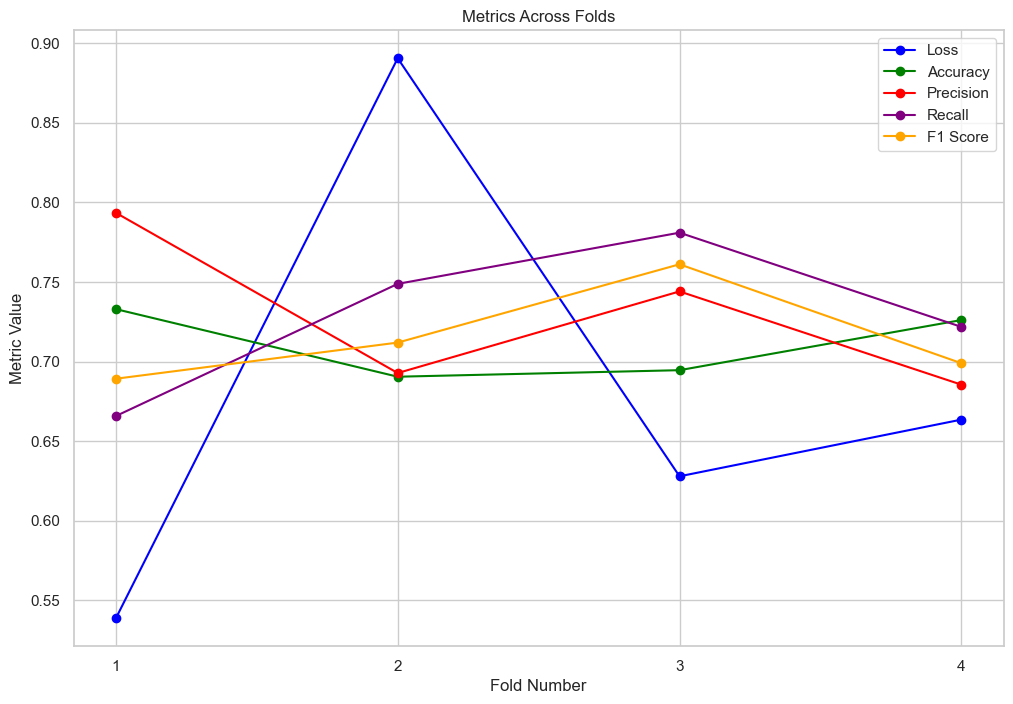

In [85]:
seed_5_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_5_training_acc_values = cv_training_acc_total

# Plotting all fold metrics|
seed_5_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [86]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 861, Predictions: 861, Actuals: 861, Gender: 861


In [87]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [88]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.72 (79/110)


In [89]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [90]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[senior, adult, adult, adult, adult, adult, ad...",adult,adult,True
81,075A,"[adult, adult, adult, senior, adult]",adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, kitten, adult, adult, adult, adult, ad...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, adult, senior, adult, se...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True
70,064A,"[adult, adult, adult]",adult,adult,True


In [91]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  73.770492           61
1           kitten  73.333333           15
2           senior  67.647059           34


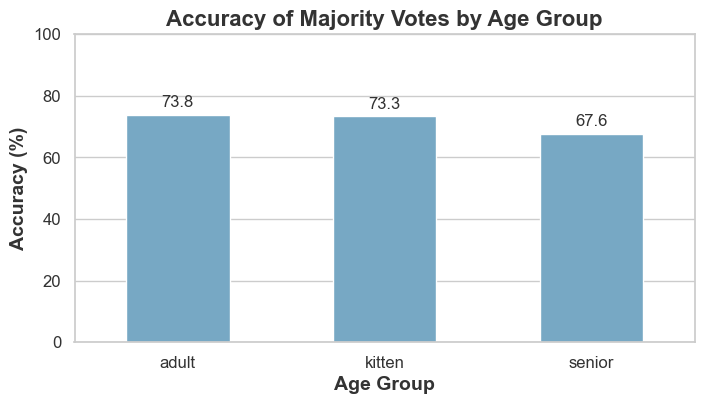

In [92]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


In [93]:
full_results

,cat_id,predicted_age_group,actual_age_group,all_gender,correct
0,093A,adult,senior,X,False
1,097A,senior,senior,X,True
2,097B,adult,adult,X,True
3,062A,adult,adult,X,True
4,062A,kitten,adult,X,False
...,...,...,...,...,...
856,047A,kitten,kitten,X,True
857,047A,kitten,kitten,X,True
858,002B,adult,adult,M,True
859,027A,senior,adult,M,False


## Detailed Class Statistics

In [94]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  70.506912          434
1           kitten  79.338843          121
2           senior  68.300654          306


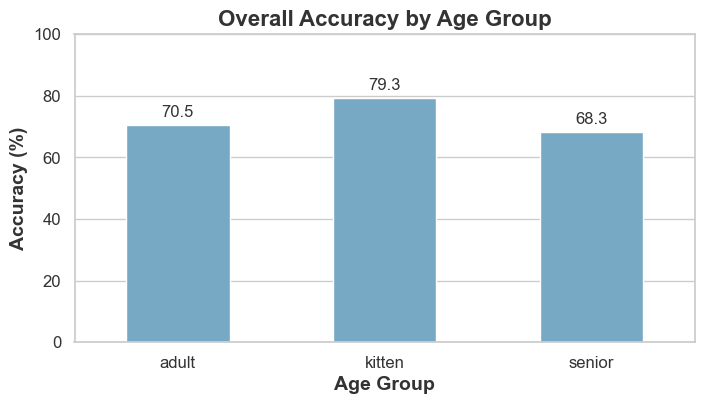

In [95]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [96]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    226      162     71.68
1          M    337      231     68.55
2          X    298      218     73.15


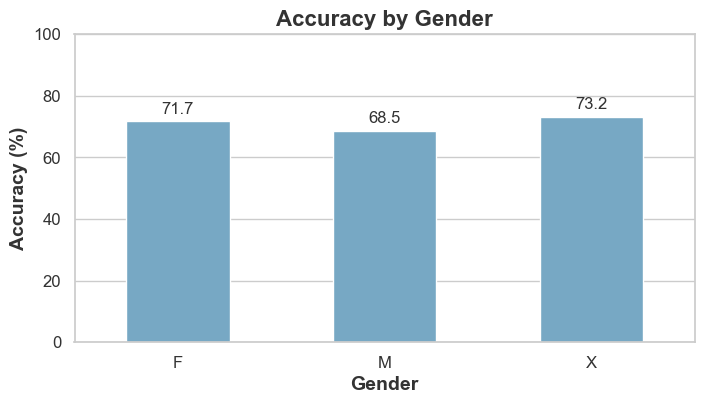

In [97]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [98]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats) 
print("Total Majority Vote Statistics so far:\n", all_majority_vote_details) 
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909, 0.7727272727272727, 0.7545454545454545, 0.7727272727272727, 0.7181818181818181]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  69.668246          422
1           kitten  82.568807          109
2           senior  65.686275          306,   actual_age_group   accuracy  total_count
0            adult  71.158392          423
1           kitten  83.486239          109
2           senior  69.607843          306,   actual_age_group   accuracy  total_count
0            adult  69.767442          430
1           kitten  80.733945          109
2           senior  71.895425          306,   actual_age_group   accuracy  total_count
0            adult  71.561772          429
1           kitten  83.760684          117
2           senior  73.529412          306,   actual_age_group   accuracy  total_count
0            adult  70.506912          434
1           kitten  79.338843          121
2       

# --------------

# Total Final Results & Analysis

In [99]:
# Count unique cat_id per age group 
unique_cats_per_age_group = dataframe.groupby('age_group')['cat_id'].nunique()

# Display the counts
print("Unique cat_id counts in original dataframe:", unique_cats_per_age_group)

Unique cat_id counts in original dataframe: age_group
adult     62
kitten    16
senior    34
Name: cat_id, dtype: int64


## Metrics

In [100]:
# Calculate overall metrics
overall_avg_loss = np.mean(all_losses)
overall_avg_acc = np.mean(all_accuracies)
overall_avg_precision = np.mean(all_precisions)
overall_avg_recall = np.mean(all_recalls)
overall_avg_f1 = np.mean(all_f1)

print("Overall Average Metrics:")
print("Loss:", overall_avg_loss)
print("Accuracy:", overall_avg_acc)
print("Precision:", overall_avg_precision)
print("Recall:", overall_avg_recall)
print("F1 Score:", overall_avg_f1)

Overall Average Metrics:
Loss: 0.7586015880107879
Accuracy: 0.7166933715343475
Precision: 0.7217248674060026
Recall: 0.7329400834917437
F1 Score: 0.718646706428353


## Majority Votes

In [101]:
# After calculating class_stats for each fold
all_majority_vote_details.append(class_stats)

# At the end, when calculating the final metrics:
total_majority_vote_details = pd.concat(all_majority_vote_details)

macro_avg_majority_vote_accuracy = (
    total_majority_vote_details.groupby('actual_age_group')['accuracy'].mean().mean()
)

print(f"Macro-Averaged Majority Vote Accuracy: {macro_avg_majority_vote_accuracy}")

# For class-wise accuracies:
macro_avg_class_accuracies = total_majority_vote_details.groupby('actual_age_group')['accuracy'].mean()

print("Macro-Averaged Class Accuracies:")
print(macro_avg_class_accuracies)

macro_avg_class_accuracies_df = macro_avg_class_accuracies.reset_index()
macro_avg_class_accuracies_df.columns = ['actual_age_group', 'accuracy']

Macro-Averaged Majority Vote Accuracy: 74.7226686667381
Macro-Averaged Class Accuracies:
actual_age_group
adult     75.409836
kitten    81.111111
senior    67.647059
Name: accuracy, dtype: float64


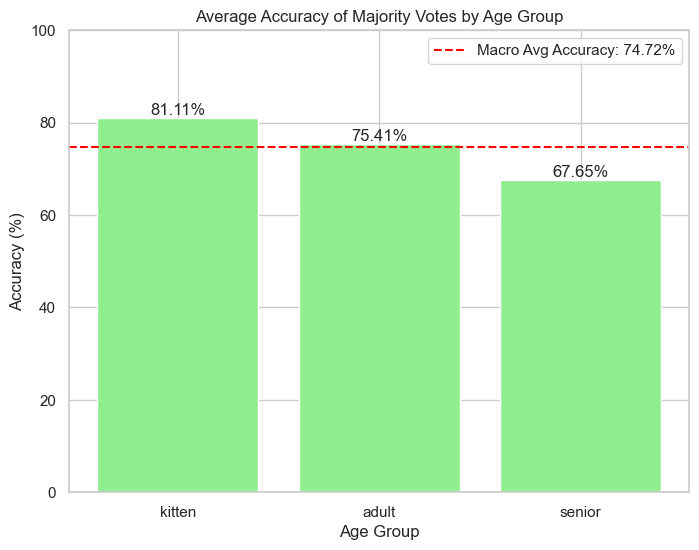

In [102]:
# Ensure that the actual_age_group is in the order of kitten, adult, senior
ordered_age_groups = ['kitten', 'adult', 'senior']
macro_avg_class_accuracies_df['actual_age_group'] = pd.Categorical(
    macro_avg_class_accuracies_df['actual_age_group'], 
    categories=ordered_age_groups, 
    ordered=True
)

# Sort the DataFrame by the defined order
macro_avg_class_accuracies_df = macro_avg_class_accuracies_df.sort_values('actual_age_group')

# Create the barplot for majority vote accuracy by age group
plt.figure(figsize=(8, 6))
bars_mv = plt.bar(macro_avg_class_accuracies_df['actual_age_group'], macro_avg_class_accuracies_df['accuracy'], color='lightgreen')

# Add average line
plt.axhline(y=macro_avg_majority_vote_accuracy, color='red', linestyle='--', label=f'Macro Avg Accuracy: {macro_avg_majority_vote_accuracy:.2f}%')

# Add labels and title
plt.xlabel('Age Group')
plt.ylabel('Accuracy (%)')
plt.title('Average Accuracy of Majority Votes by Age Group')

# Set y-axis limit to 100%
plt.ylim(0, 100)

# Add accuracy labels on bars
for bar in bars_mv:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')

# Display legend
plt.legend()

# Save the plot as a PNG file
file_path_majority_vote = "accuracy_by_majority_vote.png"
plt.savefig(file_path_majority_vote)

# Show the plot
plt.show()

# Detailed Class Statistics

In [103]:
# Calculate the average class statistics across all folds and seeds
average_class_stats = pd.concat(all_class_stats).groupby('actual_age_group').agg({
    'accuracy': 'mean',
    'total_count': 'mean'
}).reset_index()
print("Average Class Statistics across all folds and seeds:")
print(average_class_stats)

# Calculate macro-averaged accuracy
macro_accuracy = average_class_stats['accuracy'].mean()
print(f"Macro-Averaged Accuracy: {macro_accuracy:.2f}%")

# Calculate macro-averaged accuracy for detailed class statistics
macro_avg_class_accuracy = average_class_stats['accuracy'].mean()

Average Class Statistics across all folds and seeds:
  actual_age_group   accuracy  total_count
0            adult  70.532553        427.6
1           kitten  81.977704        113.0
2           senior  69.803922        306.0
Macro-Averaged Accuracy: 74.10%


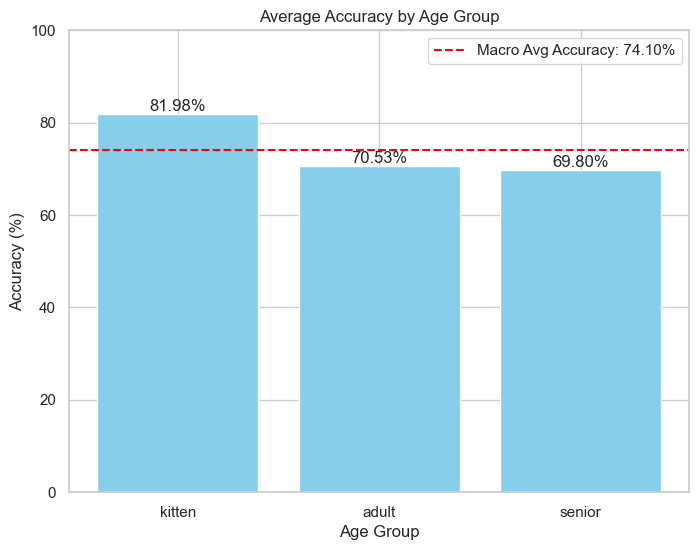

In [104]:
# Ensure that the actual_age_group is in the order of kitten, adult, senior
ordered_age_groups = ['kitten', 'adult', 'senior']
average_class_stats['actual_age_group'] = pd.Categorical(
    average_class_stats['actual_age_group'], 
    categories=ordered_age_groups, 
    ordered=True
)

# Sort the DataFrame by the defined order
average_class_stats = average_class_stats.sort_values('actual_age_group')

# Plot the barplot using the ordered age groups
age_groups = average_class_stats['actual_age_group']
accuracies = average_class_stats['accuracy']

plt.figure(figsize=(8, 6))
bars = plt.bar(age_groups, accuracies, color='skyblue')

# Add average line
plt.axhline(y=macro_avg_class_accuracy, color='red', linestyle='--', label=f'Macro Avg Accuracy: {macro_avg_class_accuracy:.2f}%')

# Set y-axis limit to 100%
plt.ylim(0, 100)

# Add labels and title
plt.xlabel('Age Group')
plt.ylabel('Accuracy (%)')
plt.title('Average Accuracy by Age Group')

# Add accuracy labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')

# Display legend
plt.legend()

# Save the plot as a PNG file
file_path_ordered = "accuracy_by_age_group.png"
plt.savefig(file_path_ordered)

# Show the plot
plt.show()


## Gender

In [105]:
# Concatenate all gender stats DataFrames
total_gender_stats = pd.concat(all_gender_stats)

# Calculate macro-averaged accuracy across all folds and seeds
avg_gender_accuracy = total_gender_stats.groupby('all_gender')['accuracy'].mean().mean()

print(f"Averaged Gender Accuracy: {avg_gender_accuracy}")

# Calculate class-wise (gender-wise) accuracies
avg_gender_accuracies = total_gender_stats.groupby('all_gender')['accuracy'].mean()

print("Macro-Averaged Gender Accuracies:")
print(avg_gender_accuracies)

# Convert the results into a DataFrame for easier handling
avg_gender_accuracies_df = avg_gender_accuracies.reset_index()
avg_gender_accuracies_df.columns = ['all_gender', 'accuracy']

Averaged Gender Accuracy: 72.08466666666666
Macro-Averaged Gender Accuracies:
all_gender
F    72.738
M    68.130
X    75.386
Name: accuracy, dtype: float64


Averaged Gender Accuracy: 72.08466666666666
  all_gender  accuracy
0          F    72.738
1          M    68.130
2          X    75.386


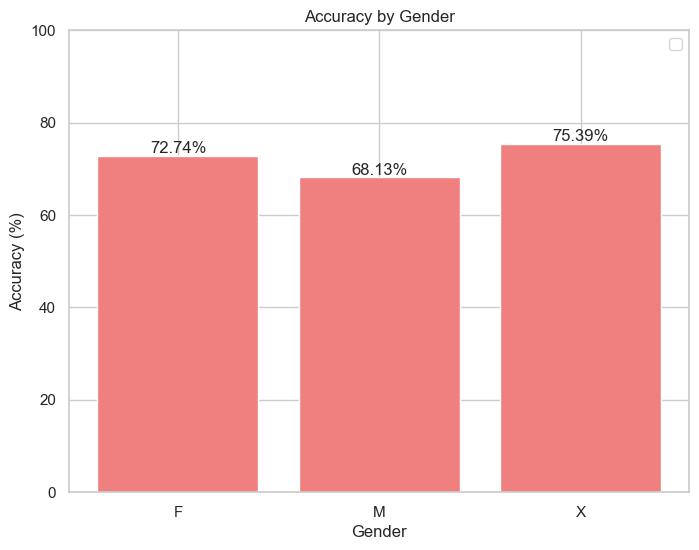

In [106]:
# Concatenate all gender stats DataFrames
total_gender_stats = pd.concat(all_gender_stats)

# Calculate averaged accuracy across all folds and seeds
avg_gender_accuracy = total_gender_stats.groupby('all_gender')['accuracy'].mean().mean()

print(f"Averaged Gender Accuracy: {avg_gender_accuracy}")

# Calculate class-wise (gender-wise) accuracies
avg_gender_accuracies = total_gender_stats.groupby('all_gender')['accuracy'].mean()

# Convert the results into a DataFrame for easier handling
avg_gender_accuracies_df = avg_gender_accuracies.reset_index()
avg_gender_accuracies_df.columns = ['all_gender', 'accuracy']

# Print the class-wise accuracies for verification
print(avg_gender_accuracies_df)

# Create the barplot for gender accuracy using the calculated class-wise accuracies
genders = avg_gender_accuracies_df['all_gender']
accuracies_gender = avg_gender_accuracies_df['accuracy']

plt.figure(figsize=(8, 6))
bars_gender = plt.bar(genders, accuracies_gender, color='lightcoral')

# Set y-axis limit to 100%
plt.ylim(0, 100)

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Gender')

# Add accuracy labels on bars
for bar in bars_gender:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')

# Display legend
plt.legend()

# Save the plot as a PNG file
file_path = "accuracy_by_gender_plot.png"
plt.savefig(file_path)

# Show the plot for gender accuracy
plt.show()


# Visualisations

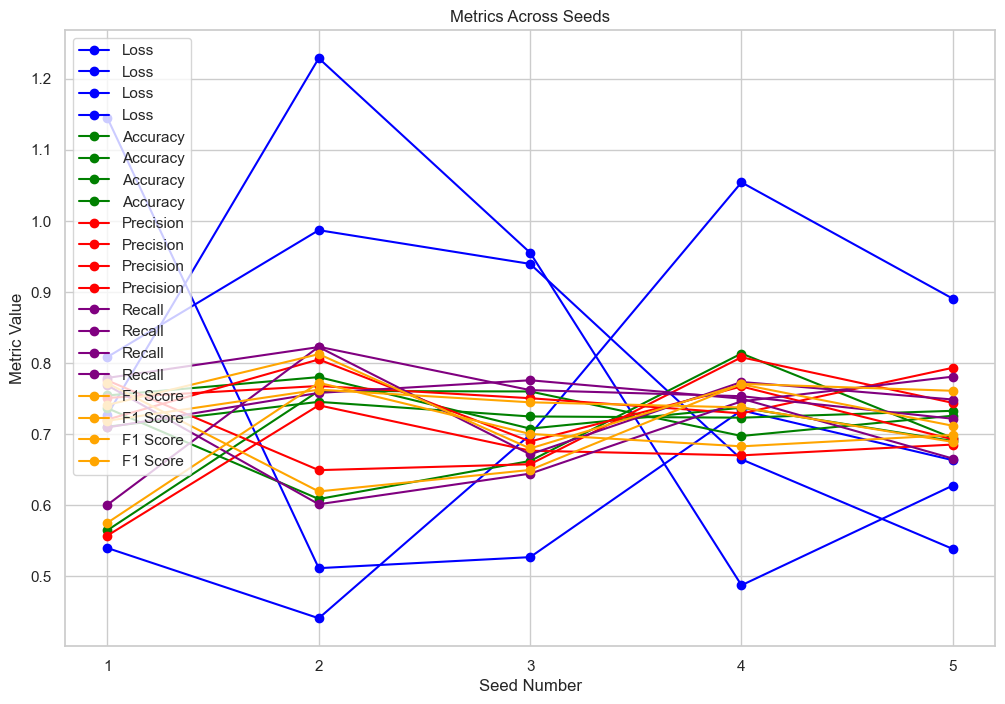

In [107]:
# Plotting all metrics
metrics_across_seeds = plot_all_metrics(all_losses, all_accuracies, all_precisions, all_recalls, all_f1, "Seeds", "Seed Number")

## Display the seed folds results together

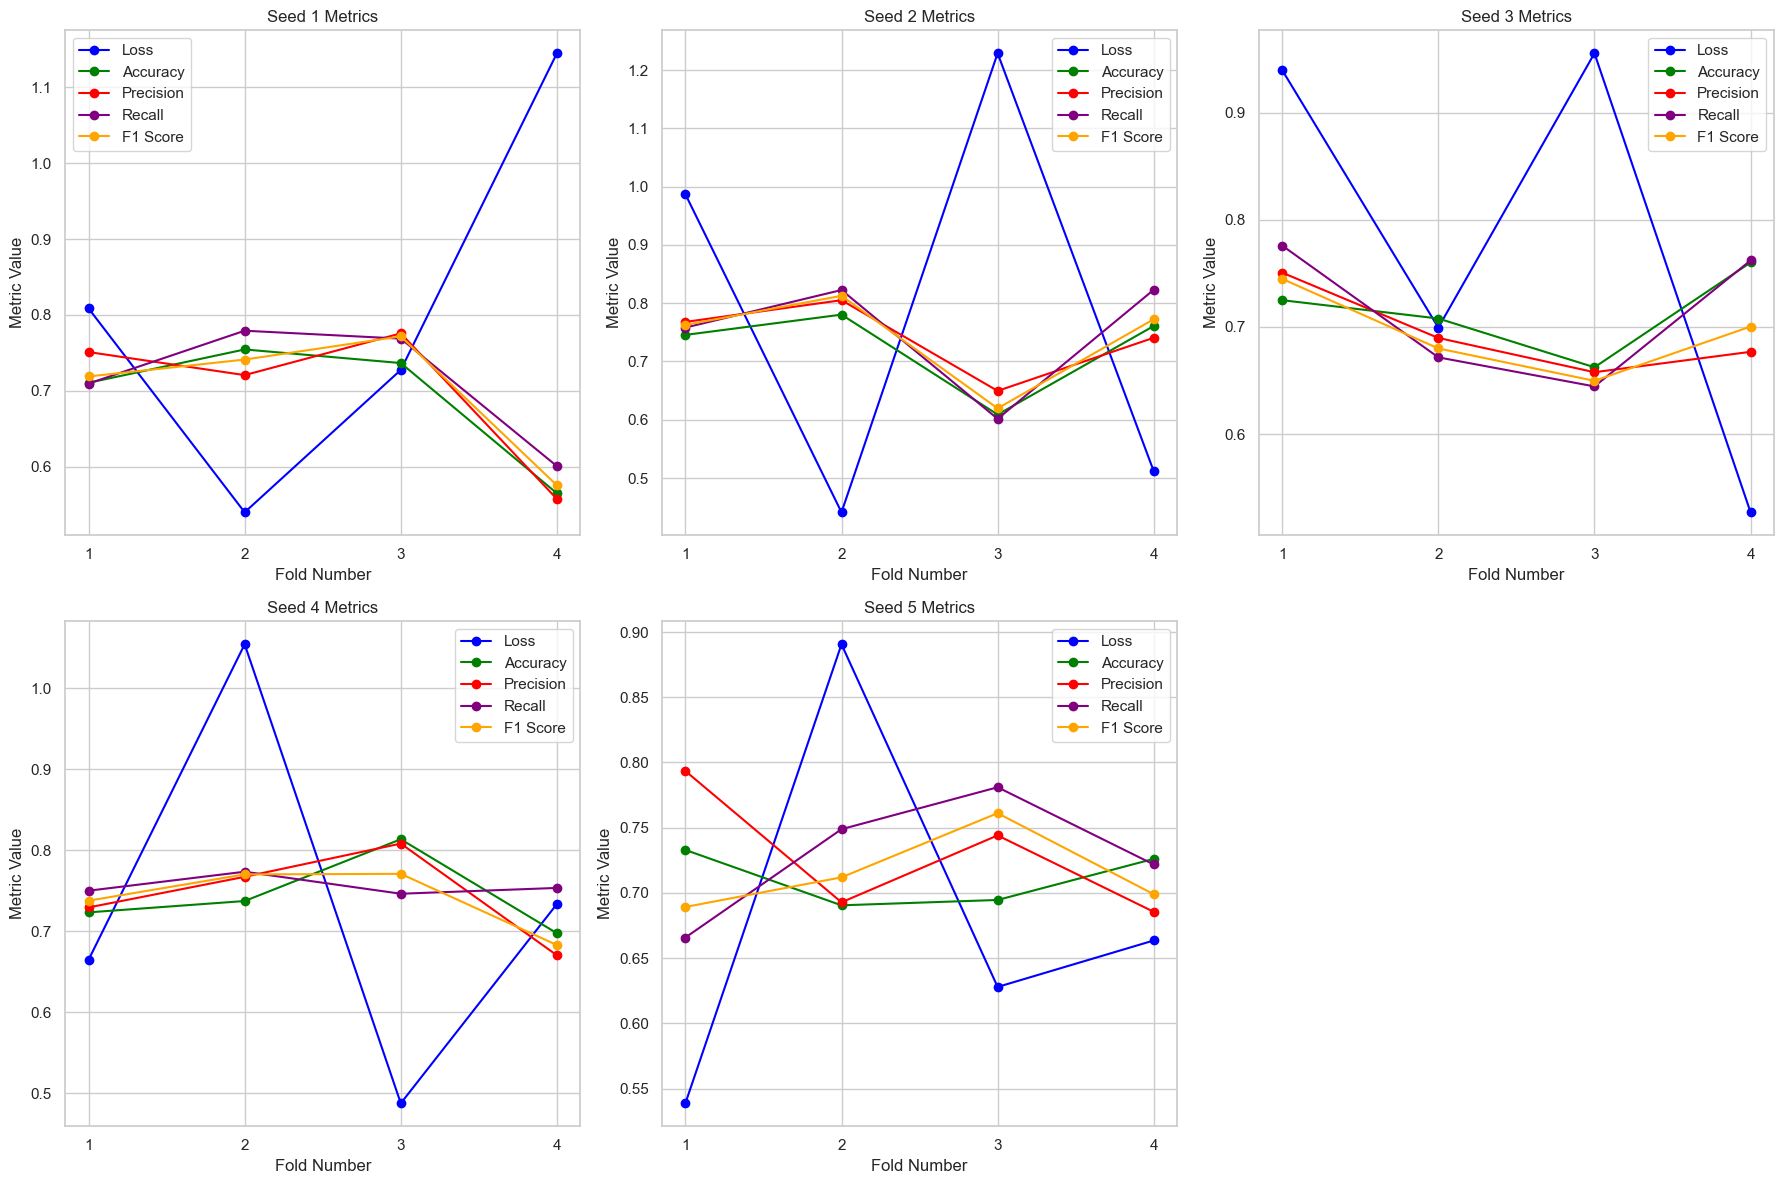

In [108]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

def plot_metrics_on_axes(ax, losses, accuracies, precisions, recalls, f1, title):
    ax.plot(range(1, len(losses)+1), losses, marker='o', color='blue', label='Loss')
    ax.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(range(1, len(precisions)+1), precisions, marker='o', color='red', label='Precision')
    ax.plot(range(1, len(recalls)+1), recalls, marker='o', color='purple', label='Recall')
    ax.plot(range(1, len(f1)+1), f1, marker='o', color='orange', label='F1 Score')
    ax.set_xticks([1, 2, 3, 4])  # Set x-axis ticks to full integers
    ax.set_title(title)
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True)

# Plot onto each axes object
plot_metrics_on_axes(axes[0], *seed_1_folds_values, "Seed 1 Metrics")
plot_metrics_on_axes(axes[1], *seed_2_folds_values, "Seed 2 Metrics")
plot_metrics_on_axes(axes[2], *seed_3_folds_values, "Seed 3 Metrics")
plot_metrics_on_axes(axes[3], *seed_4_folds_values, "Seed 4 Metrics")
plot_metrics_on_axes(axes[4], *seed_5_folds_values, "Seed 5 Metrics")

# Hide the unused subplot 
for ax in axes[5:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics

In [109]:
# Calculate the standard deviation for each metric
std_loss = np.std(all_losses)
std_accuracy = np.std(all_accuracies)
std_precision = np.std(all_precisions)
std_recall = np.std(all_recalls)
std_f1 = np.std(all_f1)

print("Standard Deviations:")
print(f"Loss: {std_loss}")
print(f"Accuracy: {std_accuracy}")
print(f"Precision: {std_precision}")
print(f"Recall: {std_recall}")
print(f"F1 Score: {std_f1}")

Standard Deviations:
Loss: 0.22651231390079588
Accuracy: 0.05480722666897039
Precision: 0.060587757313601144
Recall: 0.06304803415194771
F1 Score: 0.05687814606499287


In [110]:
# Calculate the interquartile range for each metric
iqr_loss = np.percentile(all_losses, 75) - np.percentile(all_losses, 25)
iqr_accuracy = np.percentile(all_accuracies, 75) - np.percentile(all_accuracies, 25)
iqr_precision = np.percentile(all_precisions, 75) - np.percentile(all_precisions, 25)
iqr_recall = np.percentile(all_recalls, 75) - np.percentile(all_recalls, 25)
iqr_f1 = np.percentile(all_f1, 75) - np.percentile(all_f1, 25)

print("Interquartile Ranges:")
print(f"Loss: {iqr_loss}")
print(f"Accuracy: {iqr_accuracy}")
print(f"Precision: {iqr_precision}")
print(f"Recall: {iqr_recall}")
print(f"F1 Score: {iqr_f1}")


Interquartile Ranges:
Loss: 0.40386737883090973
Accuracy: 0.05099192261695862
Precision: 0.08404130004033805
Recall: 0.07398820237106019
F1 Score: 0.07692667107802953


### Variation

In [111]:
# Calculate the variation for each metric
var_loss = np.var(all_losses)
var_accuracy = np.var(all_accuracies)
var_precision = np.var(all_precisions)
var_recall = np.var(all_recalls)
var_f1 = np.var(all_f1)

print("Variations:")
print(f"Loss: {var_loss}")
print(f"Accuracy: {var_accuracy}")
print(f"Precision: {var_precision}")
print(f"Recall: {var_recall}")
print(f"F1 Score: {var_f1}")

Variations:
Loss: 0.051307828348692686
Accuracy: 0.003003832095143899
Precision: 0.003670876336291829
Recall: 0.003975054610425164
F1 Score: 0.003235123499790664


### Levene tests for variation significance between seeds

#### Levene across seeds for LOSS

In [112]:
# Levene across seeds for LOSS
stat_val, p_val = levene(seed_1_folds_values[0], seed_2_folds_values[0], seed_3_folds_values[0], seed_4_folds_values[0], seed_5_folds_values[0])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 1.58, P-value: 0.230


#### Levene across seeds for ACCURACY

In [113]:
# Levene across seeds for ACCURACY
stat_val, p_val = levene(seed_1_folds_values[1], seed_2_folds_values[1], seed_3_folds_values[1], seed_4_folds_values[1], seed_5_folds_values[1])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.36, P-value: 0.832


#### Levene across seeds for PRECISION

In [114]:
# Levene across seeds for PRECISION
stat_val, p_val = levene(seed_1_folds_values[2], seed_2_folds_values[2], seed_3_folds_values[2], seed_4_folds_values[2], seed_5_folds_values[2])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.32, P-value: 0.860


#### Levene across seeds for RECALL

In [115]:
# Levene across seeds for RECALL
stat_val, p_val = levene(seed_1_folds_values[3], seed_2_folds_values[3], seed_3_folds_values[3], seed_4_folds_values[3], seed_5_folds_values[3])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 1.26, P-value: 0.329


#### Levene across seeds for F1

In [116]:
# Levene across seeds for F1
stat_val, p_val = levene(seed_1_folds_values[4], seed_2_folds_values[4], seed_3_folds_values[4], seed_4_folds_values[4], seed_5_folds_values[4])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.39, P-value: 0.812


## Print out measurements for future further analysis (without rerunning notebook)

In [117]:
seed_1_folds_values

[[0.80866539478302, 0.5399810671806335, 0.7275430560112, 1.144769549369812],
 [0.710659921169281,
  0.7545454502105713,
  0.7366254925727844,
  0.5649717450141907],
 [0.7511248460736951,
  0.7207310293109912,
  0.775715263981699,
  0.5575224865285717],
 [0.7095898348020588,
  0.7792361261456304,
  0.7688001202152145,
  0.6007785235744113],
 [0.7189595892834492,
  0.7412142722701729,
  0.7717340121788786,
  0.5754985754985754]]

In [118]:
seed_2_folds_values

[[0.9870322942733765,
  0.44120293855667114,
  1.2288175821304321,
  0.5116612911224365],
 [0.7455621361732483,
  0.7803738117218018,
  0.6088888645172119,
  0.760869562625885],
 [0.7678736357981641,
  0.8051651651651651,
  0.6495195112216389,
  0.74070240012269],
 [0.7581483922947337,
  0.8226190476190477,
  0.6015529018624993,
  0.823060910489637],
 [0.7627096614470509,
  0.812671669814527,
  0.6195453791272607,
  0.772469076816903]]

In [119]:
seed_3_folds_values

[[0.9395890831947327,
  0.6993897557258606,
  0.9553160667419434,
  0.5271496176719666],
 [0.7250000238418579,
  0.7079207897186279,
  0.662420392036438,
  0.7601625919342041],
 [0.7506767550514333,
  0.6897926634768741,
  0.6578291542059658,
  0.676847538532321],
 [0.7759182247073214,
  0.6716798527143354,
  0.6445656457279859,
  0.7620769832469465],
 [0.7449094115760783,
  0.6799948638931689,
  0.649781415456356,
  0.7004167433666106]]

In [120]:
seed_4_folds_values

[[0.6646968126296997,
  1.0542762279510498,
  0.48761218786239624,
  0.7336210012435913],
 [0.7233201861381531,
  0.7373272180557251,
  0.8135592937469482,
  0.6975609660148621],
 [0.7293850454227813,
  0.767206815536965,
  0.8082388510959939,
  0.6703101279548904],
 [0.7500707213578499,
  0.7734946472991436,
  0.7463159445918066,
  0.7534900284900287],
 [0.7377235358928722,
  0.7702060998919636,
  0.7708708708708709,
  0.6829898989898989]]

# Training Accuracy Analysis

In [121]:
all_best_training_acc

[0.9027026891708374,
 0.8856346011161804,
 0.8991354703903198,
 0.9092105031013489,
 0.9231770634651184,
 0.8907330632209778,
 0.9058988690376282,
 0.906647801399231,
 0.9239598512649536,
 0.8775510191917419,
 0.8782051205635071,
 0.9117221236228943,
 0.890350878238678,
 0.9208333492279053,
 0.8934210538864136,
 0.8975409865379333,
 0.8541392683982849,
 0.8963503837585449,
 0.9087193608283997,
 0.8840169906616211]

In [122]:
total_training_acc

[[0.41756758093833923,
  0.5054054260253906,
  0.5851351618766785,
  0.6432432532310486,
  0.6283783912658691,
  0.6540540456771851,
  0.6567567586898804,
  0.6499999761581421,
  0.6932432651519775,
  0.6864864826202393,
  0.6918919086456299,
  0.7135134935379028,
  0.708108127117157,
  0.7121621370315552,
  0.7378378510475159,
  0.7648648619651794,
  0.7351351380348206,
  0.7202702760696411,
  0.7486486434936523,
  0.745945930480957,
  0.7378378510475159,
  0.7594594359397888,
  0.7486486434936523,
  0.7743242979049683,
  0.7594594359397888,
  0.7621621489524841,
  0.7554054260253906,
  0.7391892075538635,
  0.7702702879905701,
  0.7621621489524841,
  0.7743242979049683,
  0.7770270109176636,
  0.7716216444969177,
  0.7405405640602112,
  0.7743242979049683,
  0.745945930480957,
  0.7635135054588318,
  0.7945945858955383,
  0.7810810804367065,
  0.8040540814399719,
  0.7756756544113159,
  0.795945942401886,
  0.7824324369430542,
  0.8027027249336243,
  0.7743242979049683,
  0.781081080

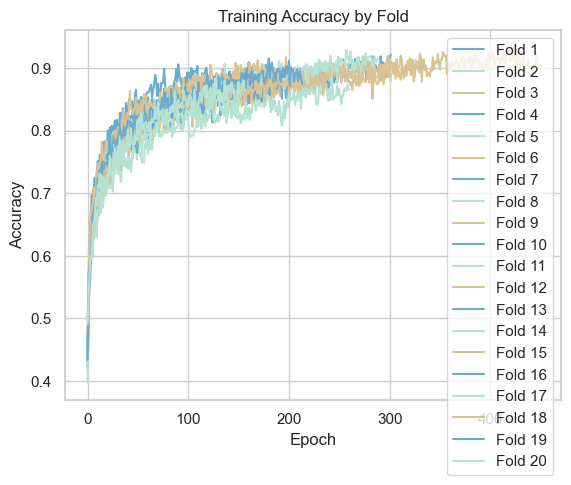

In [123]:
# Plot accuracy histories for all folds
for i, fold_accuracy in enumerate(total_training_acc):
    plt.plot(fold_accuracy, label=f'Fold {i+1}')

plt.title('Training Accuracy by Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig("VGGish_categorical_training_accuracy")

plt.legend()

plt.show()

In [124]:
# running time including analysis
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 54.73489785194397 seconds


## Confusion Heatmap

In [125]:
# Aggregate all confusion matrices
aggregate_cm = np.sum(all_confusion_matrices, axis=0)

# Normalize the confusion matrix to get percentages
cm_percentage = aggregate_cm / np.sum(aggregate_cm, axis=1, keepdims=True) * 100

In [126]:
aggregate_cm

array([[1508,  108,  522],
       [  99,  463,    3],
       [ 446,   16, 1068]])

In [127]:
class_labels = ['Adult', 'Kitten', 'Senior']

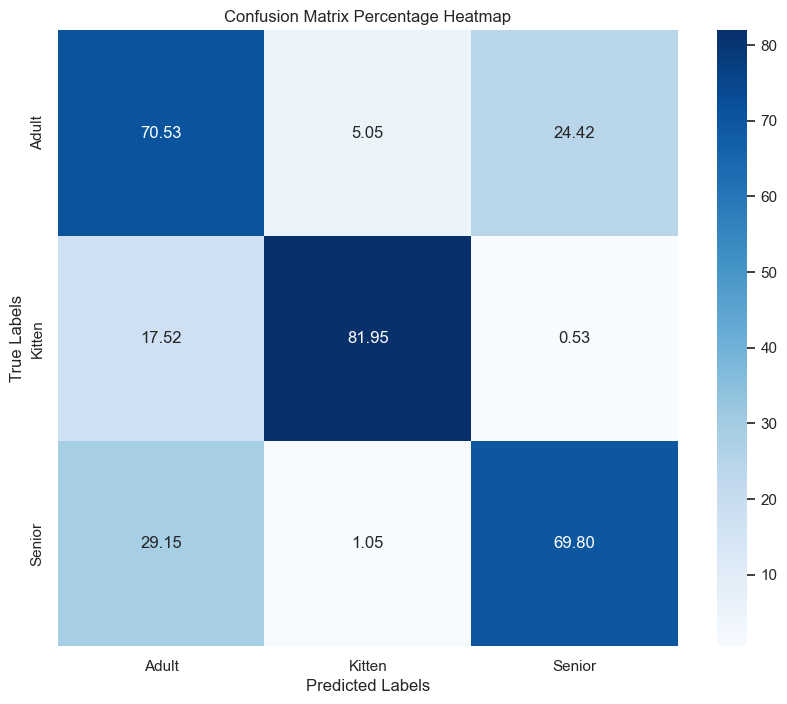

In [128]:
# Plot the percentage heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap=plt.cm.Blues, cbar=True,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix Percentage Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("cm_best.jpg")
plt.show()